## Regresja

W skrypcie tym zawarłem kod odpowiedzialny za trenowanie algorytmów regresji oraz wizualizację wyników tego uczenia.

Szczegółowy opis zawarty jest w rozdziale 4.3.2.

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial

from joblib import dump

training_set_path = '../data/training_set/'
models_save_path = '../data/models/regression/'
results_save_path = '../results/regression/'

In [2]:
data = pd.read_pickle(training_set_path + 'training_set.pkl')
X = data.drop(['new_watchers'], axis=1)
y = data['new_watchers']
s = StandardScaler()
X = s.fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=42)

In [3]:
def regression_summary(model, model_name, model_details, X_train, X_test, y_train, y_test):
    """
    Wykonuje uczenie modelu regresji, drukuje podsumowanie i zwraca metryki wymagane w dalszej analizie.
    
    Parameters
    ----------
    model
        obiekt reprezentujący model, który ma zostać wytrenowany
    model_name : str
        nazwa modelu
    model_details : str
        dodatkowe szczegóły składające się na opis modelu
    X_train : numpy.array
        tablica danych uczących
    X_test : numpy.array
        tablica danych testowych
    y_train : numpy.array
        wektor etykiet odpowiadający danym uczącym
    y_test : numpy.array
        wektor etykiet odpowiadający danym testowym
    """
    
    print(f'\nModel: {model_name}\n{model_details}')
    
    model.fit(X_train, y_train)
    dump(model, f'{models_save_path}{model_name} - {model_details}.joblib'.replace('\n', ' '))
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    train_s = model.score(X_train, y_train)
    test_s = model.score(X_test, y_test)
    
    print(f'Średni błąd kwadratowy na danych testowych: {mse}')
    print(f'R^2 dla danych uczących: {train_s}')
    print(f'R^2 dla danych testowych: {test_s}')

    return y_pred, mse, train_s, test_s

In [4]:
def compare_model_versions(x_num, y_num, y, y_preds, names, title, 
                           save_path, size_x=15, size_y=15):
    """
    Generuje wykresy, pozwalające porównać różne modele regresji, sprawdzając 
    zgodność otrzymanych wyników z wynikami wzorcowymi.
    
    Parameters
    ----------
    x_num : int
        ilośc wierszy w siatce wykresów
    y_num : int
        ilość kolumn w siatce wykresów
    y : numpy.array
        wektor zawierający prawidłowe odpowiedzi, które powinien zwrócić model
    y_preds : numpy.array
        wektor zawierający odpowiedzi zwrócone przez model regresji
    names : list
        lista tytułów poszczególnych wykresów
    title : str
        tytuł głowny zbioru wykresów
    save_path : str
        ścieżka, pod którą zostanie zapisany wygenerowany wykres (zawierający nazwę pliku wraz z rozszerzeniem)
    size_x : int, optional
        szerokość wykresu
    size_y : int, optional
        wysokość wykresu
    """
    
    
    fig = plt.figure(figsize=(size_x, size_y))
    fig.subplots_adjust(hspace=0.40, wspace=0.40)
    fig.suptitle(title, fontsize=20)
    for y_pred, name, i in zip(y_preds, names, range(1, x_num*y_num+1)):
        ax = fig.add_subplot(x_num, y_num, i)
        p = Polynomial.fit(y.values, y_pred, 1)
        
        ax.scatter(y.values, y_pred, marker=".")
        ax.plot(*p.linspace(), color='r')
        ax.plot(y.values, y.values, color='g')
        
        ax.set_xlabel('Wartości rzeczywiste', fontsize=12)
        ax.set_ylabel('Wartości przewidywane', fontsize=12)
        ax.set_title(name, fontsize=12)
    plt.savefig(save_path)

In [5]:
def compare_mses(mses, names, title, save_path, size_x=20, size_y=10):
    """
    Generuje wykres porównujący średnie błędy kwadratowe dla różnych modeli.
    
    Parameters
    ----------
    mses : list
        lista średnich błędów kwadratowych do porównania
    names : list
        lista nazw modeli, dla których uzyskano odpowiednie MSE
    save_path : str
        ścieżka, pod którą zostanie zapisany wygenerowany wykres (zawierający nazwę pliku wraz z rozszerzeniem)
    size_x : int, optional
        szerokość wykresu
    size_y : int, optional
        wysokość wykresu
    """
    
    barDim = 0.45
    plt.figure(figsize=(size_x, size_y))
    plt.rcParams.update({'font.size': 10})
    
    r = np.arange(len(names))
    plt.barh(r, mses, height=barDim)
    plt.xlabel('Średni błąd kwadratowy', fontsize=15)
    plt.yticks([label for label in range(len(names))], names)
    plt.title(title, fontsize=20)
    plt.savefig(save_path)

In [6]:
def compare_scores(train_scores, test_scores, names, title, 
                   save_path, size_x=20, size_y=10):
    """
    Generuje wykres porównujący współczynnik R^2 dla różnych modeli na danych treningowych i testowych.
    
    Parameters
    ----------
    train_scores : list
        lista uzyskanych na danych treningowych współczynników R^2
    test_scores : list
        lista uzyskanych na danych testowych współczynników R^2
    names : list
        lista nazw modeli, dla których wykonuje porównanie
    title : str
        tytuł wykresu
    save_path : str
        ścieżka, pod którą zostanie zapisany wygenerowany wykres (zawierający nazwę pliku wraz z rozszerzeniem)
    size_x : int, optional
        szerokość wykresu
    size_y : int, optional
        wysokość wykresu
    """
    
    barDim = 0.45
    plt.figure(figsize=(size_x, size_y))
    plt.rcParams.update({'font.size': 10})

    r1 = np.arange(len(names))
    r2 = [x + barDim for x in r1]
    plt.barh(r1, train_scores, height=barDim, 
             edgecolor='white', label='dane treningowe')
    plt.barh(r2, test_scores, height=barDim, 
             edgecolor='white', label='dane testowe')
    plt.xlabel('Współczynnik determinacji $R^2$', fontsize=15)
    plt.yticks([r +  barDim/2 for r in range(len(names))], names)
    plt.title(title, fontsize=20)
    plt.legend(fontsize=12)
    plt.savefig(save_path)

In [7]:
best_model_names = []
best_models_mses = []
best_models_train_scores = []
best_models_test_scores = []

---

### Las losowy

In [8]:
models = [
    RandomForestRegressor(n_jobs=6, max_depth=3, n_estimators=100, random_state=42),
    RandomForestRegressor(n_jobs=6, max_depth=3, n_estimators=200, random_state=42),
    RandomForestRegressor(n_jobs=6, max_depth=3, n_estimators=400, random_state=42),
    RandomForestRegressor(n_jobs=6, max_depth=4, n_estimators=100, random_state=42),
    RandomForestRegressor(n_jobs=6, max_depth=4, n_estimators=200, random_state=42),
    RandomForestRegressor(n_jobs=6, max_depth=4, n_estimators=400, random_state=42),
    RandomForestRegressor(n_jobs=6, max_depth=5, n_estimators=100, random_state=42),
    RandomForestRegressor(n_jobs=6, max_depth=5, n_estimators=200, random_state=42),
    RandomForestRegressor(n_jobs=6, max_depth=5, n_estimators=400, random_state=42),
]

In [9]:
names = [
    'głębokość=3\nliczba drzew=100', 
    'głębokość=3\nliczba drzew=200', 
    'głębokość=3\nliczba drzew=400',
    'głębokość=4\nliczba drzew=100', 
    'głębokość=4\nliczba drzew=200', 
    'głębokość=4\nliczba drzew=400',
    'głębokość=5\nliczba drzew=100', 
    'głębokość=5\nliczba drzew=200', 
    'głębokość=5\nliczba drzew=400',
]

In [10]:
y_preds = []
mean_squared_errors = []
train_scores = []
test_scores = []

In [11]:
for forest, name in zip(models, names):
    y_pred, mse, train_s, test_s = \
        regression_summary(forest, 'Las losowy', name, 
                           X_train, X_test, y_train, y_test)
    y_preds.append(y_pred)
    mean_squared_errors.append(mse)
    train_scores.append(train_s)
    test_scores.append(test_s)


Model: Las losowy
głębokość=3
liczba drzew=100
Średni błąd kwadratowy na danych testowych: 130.9777964886726
R^2 dla danych uczących: 0.4075264472105471
R^2 dla danych testowych: 0.5083619917256205

Model: Las losowy
głębokość=3
liczba drzew=200
Średni błąd kwadratowy na danych testowych: 130.02608553537277
R^2 dla danych uczących: 0.4077850366097886
R^2 dla danych testowych: 0.5119343321533639

Model: Las losowy
głębokość=3
liczba drzew=400
Średni błąd kwadratowy na danych testowych: 126.94257096706482
R^2 dla danych uczących: 0.4089601918053912
R^2 dla danych testowych: 0.5235086065837562

Model: Las losowy
głębokość=4
liczba drzew=100
Średni błąd kwadratowy na danych testowych: 136.6065301272363
R^2 dla danych uczących: 0.5438827226925276
R^2 dla danych testowych: 0.4872339878245181

Model: Las losowy
głębokość=4
liczba drzew=200
Średni błąd kwadratowy na danych testowych: 132.36844583962335
R^2 dla danych uczących: 0.5480789917559297
R^2 dla danych testowych: 0.503142052961659

Mo

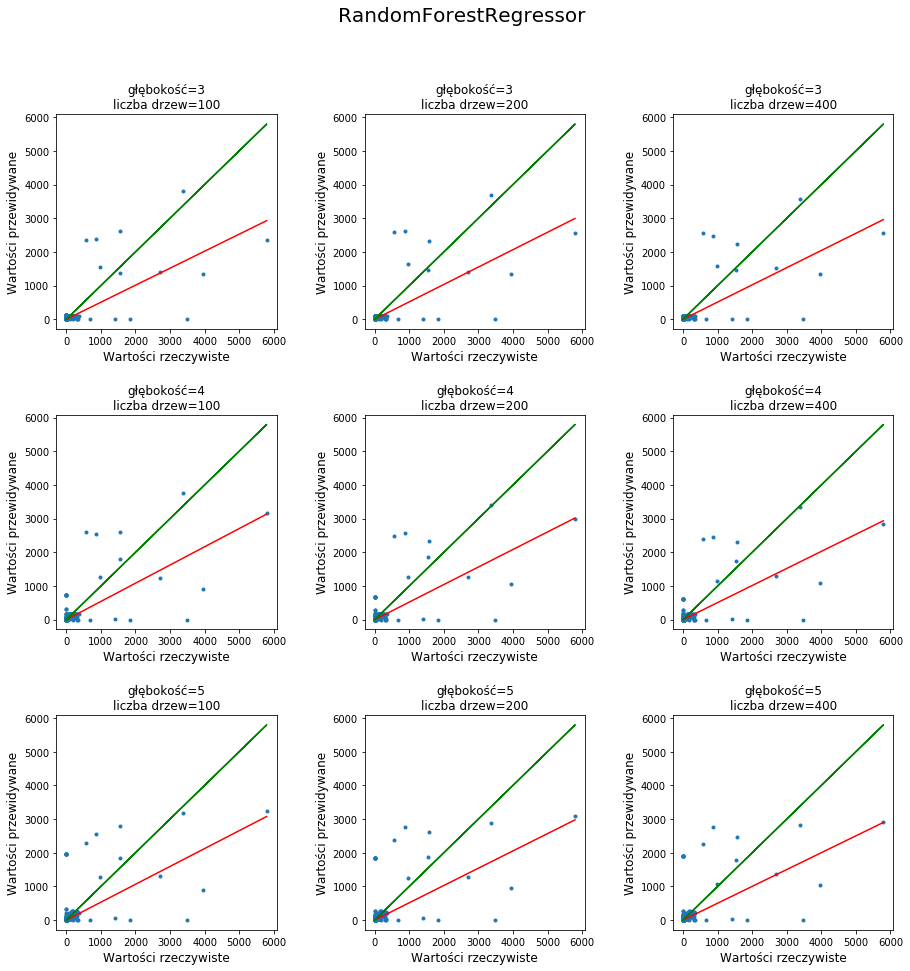

In [12]:
compare_model_versions(3, 3, y_test, y_preds, names, 'RandomForestRegressor',
                      results_save_path + 'las losowy - porównanie parametrów.jpg')

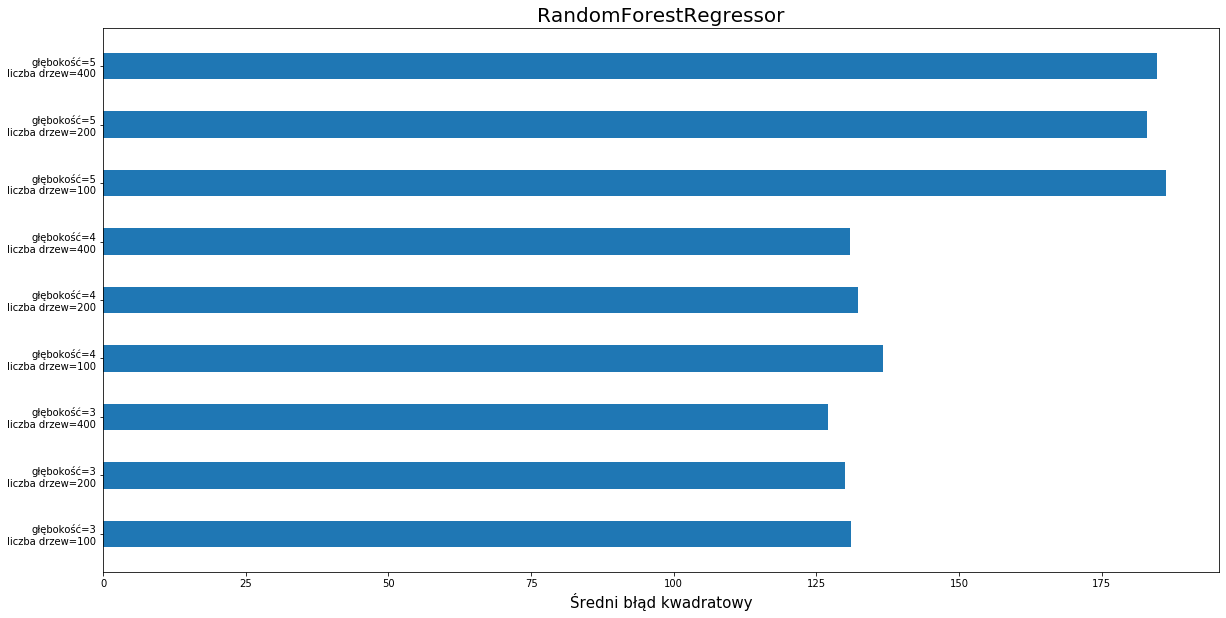

In [13]:
compare_mses(mean_squared_errors, names, 'RandomForestRegressor', 
              results_save_path + 'las losowy - MSE.jpg')

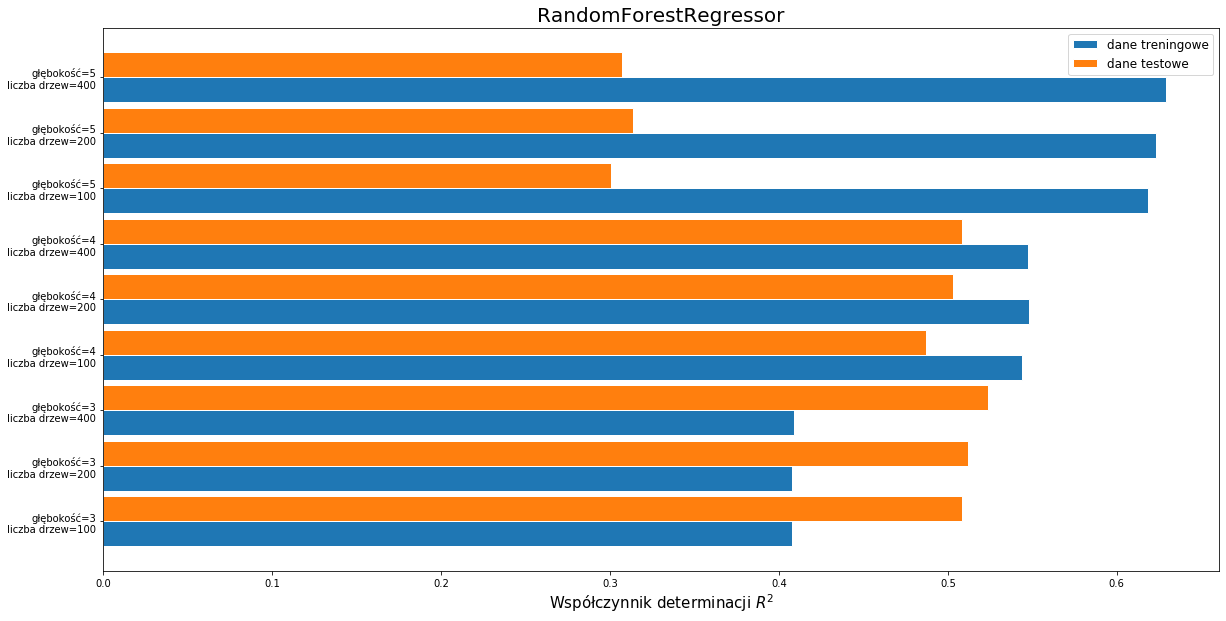

In [14]:
compare_scores(train_scores, test_scores, names, 'RandomForestRegressor', 
              results_save_path + 'las losowy - R^2.jpg')

In [15]:
best_model_names.append('Las losowy')
best_models_mses.append(mean_squared_errors[5])
best_models_train_scores.append(train_scores[5])
best_models_test_scores.append(test_scores[5])

---

### Drzewo decyzyjne

In [16]:
models = [
    DecisionTreeRegressor(max_depth=2, random_state=42),
    DecisionTreeRegressor(max_depth=3, random_state=42),
    DecisionTreeRegressor(max_depth=4, random_state=42),
    DecisionTreeRegressor(max_depth=5, random_state=42),
]

In [17]:
names = [
    'głebokość=2',
    'głębokość=3',
    'głębokość=4',
    'głębokość=5',
]

In [18]:
y_preds = []
mean_squared_errors = []
train_scores = []
test_scores = []

In [19]:
for tree, name in zip(models, names):
    y_pred, mse, train_s, test_s = \
        regression_summary(tree, 'Drzewo decyzyjne', name, X_train, X_test, y_train, y_test)
    y_preds.append(y_pred)
    mean_squared_errors.append(mse)
    train_scores.append(train_s)
    test_scores.append(test_s)


Model: Drzewo decyzyjne
głebokość=2
Średni błąd kwadratowy na danych testowych: 123.60215558270211
R^2 dla danych uczących: 0.21303775280804793
R^2 dla danych testowych: 0.5360471834296355

Model: Drzewo decyzyjne
głębokość=3
Średni błąd kwadratowy na danych testowych: 138.51999373833107
R^2 dla danych uczących: 0.3614488581869103
R^2 dla danych testowych: 0.4800516144460999

Model: Drzewo decyzyjne
głębokość=4
Średni błąd kwadratowy na danych testowych: 128.80282815912318
R^2 dla danych uczących: 0.5275700137109008
R^2 dla danych testowych: 0.516525948718835

Model: Drzewo decyzyjne
głębokość=5
Średni błąd kwadratowy na danych testowych: 216.1816980837427
R^2 dla danych uczących: 0.601680718457335
R^2 dla danych testowych: 0.18854078843465472


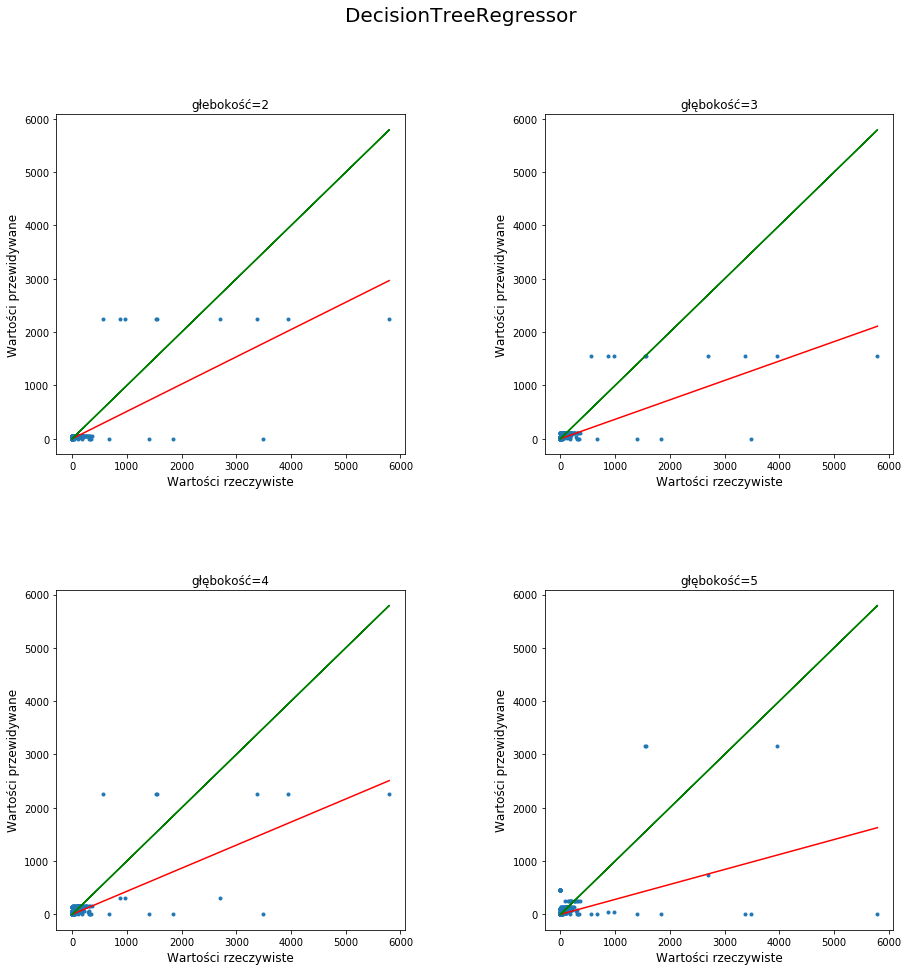

In [20]:
compare_model_versions(2, 2, y_test, y_preds, names, 'DecisionTreeRegressor',
                      results_save_path + 'drzewo decyzyjne - porównanie parametrów.jpg', 15, 15)

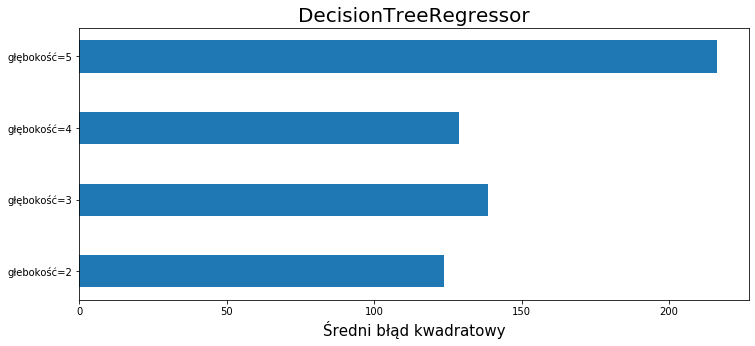

In [21]:
compare_mses(mean_squared_errors, names, 'DecisionTreeRegressor',
              results_save_path + 'drzewo decyzyjne - MSE.jpg', 12, 5)

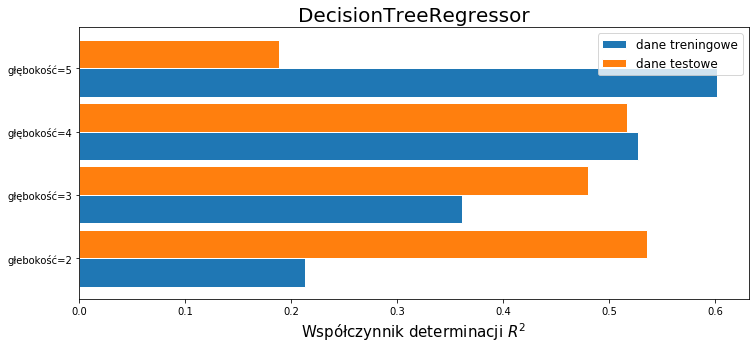

In [22]:
compare_scores(train_scores, test_scores, names, 'DecisionTreeRegressor',
              results_save_path + 'drzewo decyzyjne - R^2.jpg', 12, 5)

In [23]:
best_model_names.append('Drzewo decyzyjne')
best_models_mses.append(mean_squared_errors[2])
best_models_train_scores.append(train_scores[2])
best_models_test_scores.append(test_scores[2])

---

### Wzmocnienie gradientowe

In [24]:
models = [
    GradientBoostingRegressor(n_estimators=32, random_state=42),
    GradientBoostingRegressor(n_estimators=32, max_depth=2, random_state=42),
    GradientBoostingRegressor(n_estimators=64, max_depth=2, random_state=42),
    GradientBoostingRegressor(n_estimators=128, max_depth=2, random_state=42),
]

In [25]:
names = [
    'liczba drzew=32\ngłębokość=3',
    'liczba drzew=32\ngłębokość=2',
    'liczba drzew=64\ngłębokość=2',
    'liczba drzew=128\ngłębokość=2',
]

In [26]:
y_preds = []
mean_squared_errors = []
train_scores = []
test_scores = []

In [27]:
for gradient_boost, name in zip(models, names):
    y_pred, mse, train_s, test_s = \
        regression_summary(gradient_boost, 'Wzmocnienie gradientowe', name, X_train, X_test, y_train, y_test)
    y_preds.append(y_pred)
    mean_squared_errors.append(mse)
    train_scores.append(train_s)
    test_scores.append(test_s)


Model: Wzmocnienie gradientowe
liczba drzew=32
głębokość=3
Średni błąd kwadratowy na danych testowych: 165.80654091826716
R^2 dla danych uczących: 0.5684398252360214
R^2 dla danych testowych: 0.37762888274753403

Model: Wzmocnienie gradientowe
liczba drzew=32
głębokość=2
Średni błąd kwadratowy na danych testowych: 123.9563350469221
R^2 dla danych uczących: 0.3375560014326613
R^2 dla danych testowych: 0.5347177360650521

Model: Wzmocnienie gradientowe
liczba drzew=64
głębokość=2
Średni błąd kwadratowy na danych testowych: 145.4246103429772
R^2 dla danych uczących: 0.4460103024247395
R^2 dla danych testowych: 0.45413445866542523

Model: Wzmocnienie gradientowe
liczba drzew=128
głębokość=2
Średni błąd kwadratowy na danych testowych: 179.50315301243756
R^2 dla danych uczących: 0.5212662531266015
R^2 dla danych testowych: 0.32621730559012563


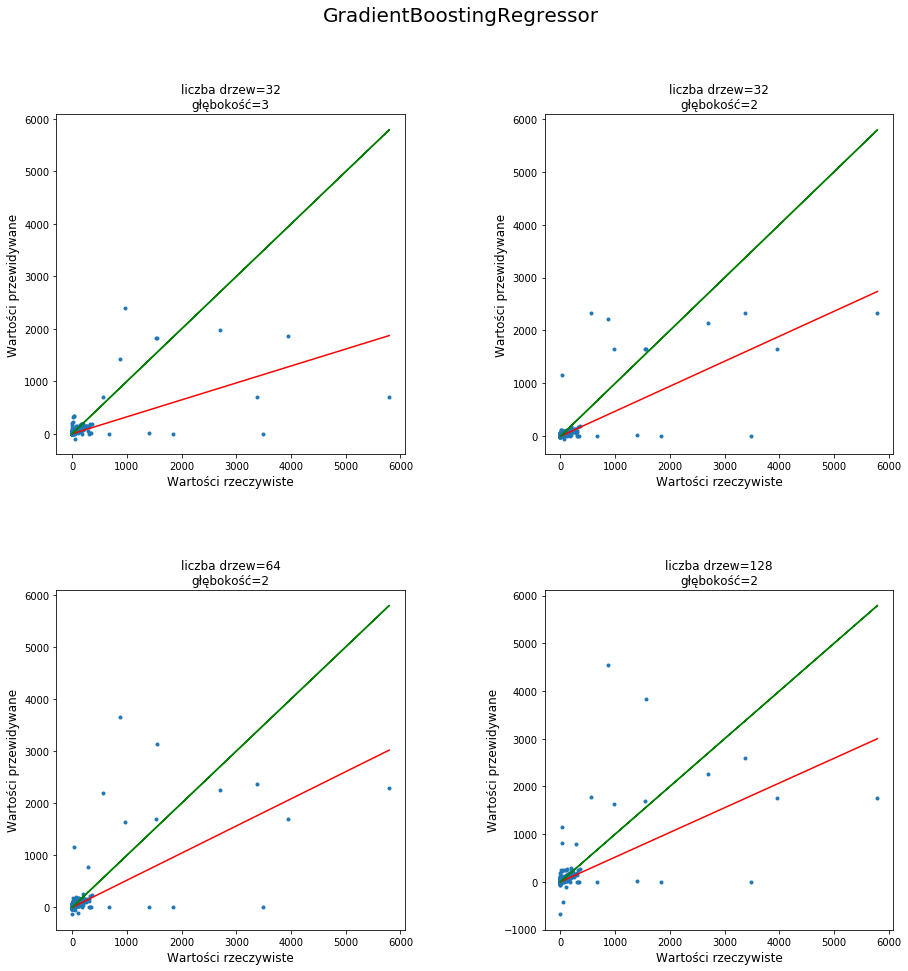

In [28]:
compare_model_versions(2, 2, y_test, y_preds, names, 'GradientBoostingRegressor',
                      results_save_path + 'wzmocnienie gradientowe - porównanie parametrów.jpg', 15, 15)

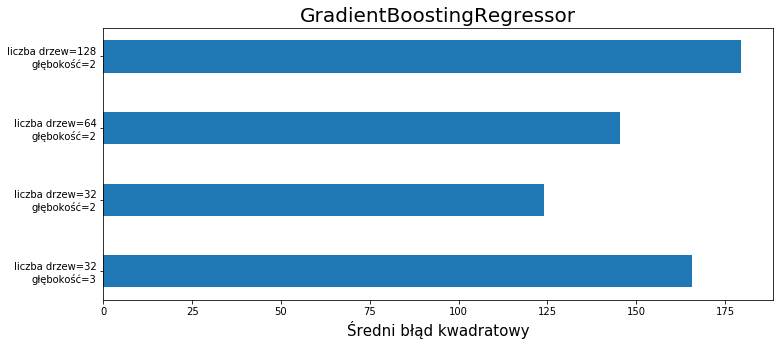

In [29]:
compare_mses(mean_squared_errors, names, 'GradientBoostingRegressor',
              results_save_path + 'wzmocnienie gradientowe - MSE.jpg', 12, 5)

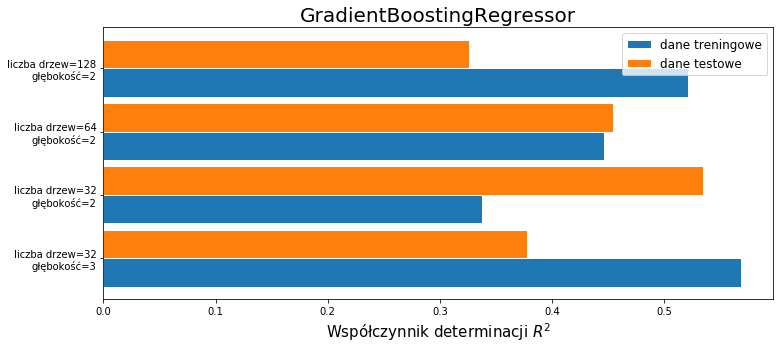

In [30]:
compare_scores(train_scores, test_scores, names, 'GradientBoostingRegressor',
              results_save_path + 'wzmocnienie gradientowe - R^2.jpg', 12, 5)

In [31]:
best_model_names.append('Wzmocnienie\ngradientowe')
best_models_mses.append(mean_squared_errors[2])
best_models_train_scores.append(train_scores[2])
best_models_test_scores.append(test_scores[2])

---

### Porównanie modeli regresji

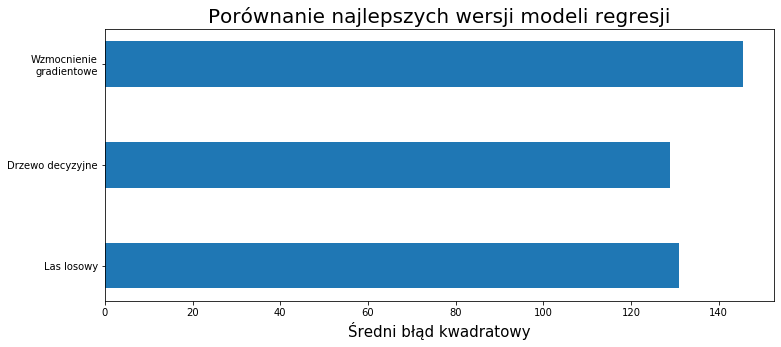

In [32]:
compare_mses(best_models_mses, best_model_names, 
             'Porównanie najlepszych wersji modeli regresji',
              results_save_path + 'porównanie modeli - MSE.jpg', 12, 5)

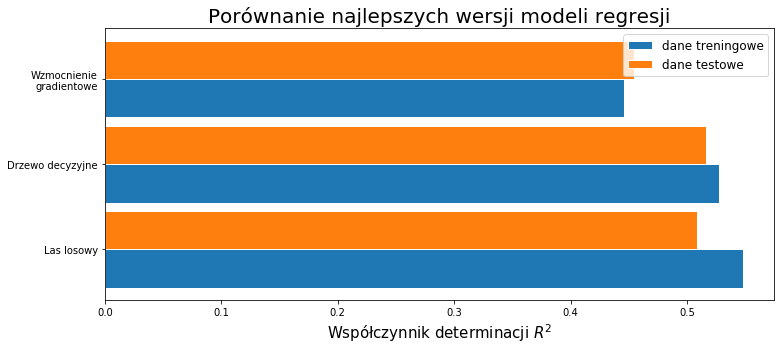

In [33]:
compare_scores(best_models_train_scores, best_models_test_scores, best_model_names, 
               'Porównanie najlepszych wersji modeli regresji',
               results_save_path + 'porównanie modeli - R^2.jpg', 12, 5)

---

### Przykład źle dobranego modelu

In [34]:
models = [
    LinearRegression(),
]

In [35]:
names = [
    'LinearRegression',
]

In [36]:
y_preds = []
mean_squared_errors = []
train_scores = []
test_scores = []

In [37]:
for model, name in zip(models, names):
    y_pred, mse, train_s, test_s = \
        regression_summary(model, 'Regresja liniowa', name, X_train, X_test, y_train, y_test)
    y_preds.append(y_pred)
    mean_squared_errors.append(mse)
    train_scores.append(train_s)
    test_scores.append(test_s)


Model: Regresja liniowa
LinearRegression
Średni błąd kwadratowy na danych testowych: 257.800307226784
R^2 dla danych uczących: 0.018711741434586315
R^2 dla danych testowych: 0.032321256156874534


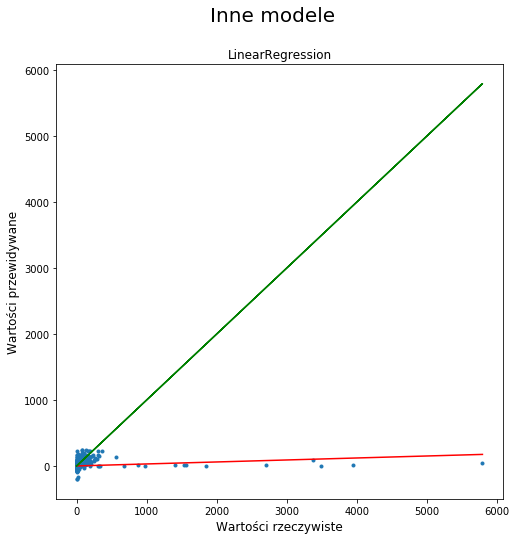

In [38]:
compare_model_versions(1, 1, y_test, y_preds, names, 'Inne modele',
                      results_save_path + 'regresja liniowa - błędny model.jpg', 8, 8)